In [6]:
import os
import pandas as pd
import numpy as np
import glob
import re
import seaborn as sns 
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import cmcrameri.cm as cmc

In [2]:
os.chdir("/Volumes/TwoTeras/")

## Creation of map data session segregated

In [3]:
data_frame = pd.read_csv("/Volumes/TwoTeras/1_Experiment_2/Eye_Tracking/Pre_processed/Data_Sets/Complete_Data_AngularV.cvs")
data_frame1 = pd.read_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Complete_Data_AngularV.cvs")

In [4]:
# Function to process the data frame
def process_data(df):
    # Select and rename columns
    processed_df = df[["SubjectID", "Session", "SessionSubsection", "timeStampDataPointEnd", 
                       "playerBodyPosition.x", "playerBodyPosition.z"]].copy()
    # Round coordinates
    processed_df['playerBodyPosition_X_Rounded'] = processed_df['playerBodyPosition.x'].round(1)
    processed_df['playerBodyPosition_Z_Rounded'] = processed_df['playerBodyPosition.z'].round(1)
    processed_df['timeformat'] = pd.to_datetime(processed_df['timeStampDataPointEnd'], unit='s')
    return processed_df

# Assuming data_frame and data_frame1 are your original data frames
Map_data = process_data(data_frame)
Map_data1 = process_data(data_frame1)

# Concatenate the two data frames
concatenated_data = pd.concat([Map_data, Map_data1], ignore_index=True)

In [5]:
Map_data1.head()

,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,playerBodyPosition.x,playerBodyPosition.z,playerBodyPosition_X_Rounded,playerBodyPosition_Z_Rounded,timeformat
0,479,2,1,1.653045e+09,-59.099869,34.795731,-59.1,34.8,2022-05-20 11:17:02.206556928
1,479,2,1,1.653045e+09,-59.099869,34.795731,-59.1,34.8,2022-05-20 11:17:02.213004288
2,479,2,1,1.653045e+09,-59.099869,34.795731,-59.1,34.8,2022-05-20 11:17:02.224909056
3,479,2,1,1.653045e+09,-59.099869,34.795731,-59.1,34.8,2022-05-20 11:17:02.236317184
4,479,2,1,1.653045e+09,-59.099869,34.795731,-59.1,34.8,2022-05-20 11:17:02.258141696


In [6]:
# Define a function for resampling within each group
def resample_group(group):
    resampled = group.resample('1S', on='timeformat').first()
    return resampled.reset_index()  # Resetting the index here

# Group by Participant ID, Session, and SessionSubsection, and apply the resampling function
# The 'group_keys=False' prevents the group keys from becoming an index
resampled_data = concatenated_data.groupby(["SubjectID", "Session", "SessionSubsection"], group_keys=False).apply(resample_group)
resampled_data1 = Map_data1.groupby(["SubjectID", "Session", "SessionSubsection"], group_keys=False).apply(resample_group)
resampled_data2 = Map_data.groupby(["SubjectID", "Session", "SessionSubsection"], group_keys=False).apply(resample_group)

# Drop rows where either of the specified columns is NaN
resampled_data = resampled_data.dropna(subset=['playerBodyPosition_Z_Rounded', 'playerBodyPosition_X_Rounded'])
resampled_data1 = resampled_data1.dropna(subset=['playerBodyPosition_Z_Rounded', 'playerBodyPosition_X_Rounded'])
resampled_data2 = resampled_data2.dropna(subset=['playerBodyPosition_Z_Rounded', 'playerBodyPosition_X_Rounded'])

# Define a function to remove the first two seconds of each session for each group
def remove_first_two_seconds(group):
    group = group.sort_values(by='timeformat')
    start_time = group['timeformat'].iloc[0]
    two_seconds_later = start_time + pd.Timedelta(seconds=2)
    return group[group['timeformat'] > two_seconds_later]

# Apply the remove_first_two_seconds function with group_keys=False
resampled_data_2S = resampled_data.groupby(["SubjectID", "Session", "SessionSubsection"], group_keys=False).apply(remove_first_two_seconds)
resampled_data_2S1 = resampled_data1.groupby(["SubjectID", "Session", "SessionSubsection"], group_keys=False).apply(remove_first_two_seconds)
resampled_data_2S2 = resampled_data2.groupby(["SubjectID", "Session", "SessionSubsection"], group_keys=False).apply(remove_first_two_seconds)
# Select only the rounded position columns and drop rows with NaN values
final_data = resampled_data_2S[['playerBodyPosition_Z_Rounded', 'playerBodyPosition_X_Rounded']].dropna()
final_data1 = resampled_data_2S1[['playerBodyPosition_Z_Rounded', 'playerBodyPosition_X_Rounded']].dropna()
final_data2 = resampled_data_2S1[['playerBodyPosition_Z_Rounded', 'playerBodyPosition_X_Rounded']].dropna()

# Display the first few rows of the final data
final_data.head()


,playerBodyPosition_Z_Rounded,playerBodyPosition_X_Rounded
3,34.8,-59.1
4,34.8,-59.1
5,34.8,-59.1
6,34.8,-59.1
7,34.8,-59.1


In [7]:
resampled_data_2S.SubjectID.unique()

array([ 365.,  479., 1031., 1142., 1234., 1268., 1574., 1754., 1843.,
       2069., 2258., 2361., 2693., 3193., 3246., 3310., 3540., 3572.,
       3976., 4176., 4580., 4597., 4598., 4796., 4847., 4875., 4917.,
       5161., 5189., 5191., 5238., 5531., 5741., 5743., 5766., 5851.,
       5972., 6266., 6406., 6642., 7081., 7093., 7264., 7393., 7412.,
       7823., 7842., 7935., 8007., 8469., 8629., 8673., 8695., 9297.,
       9472., 9502., 9586., 9601., 9627.])

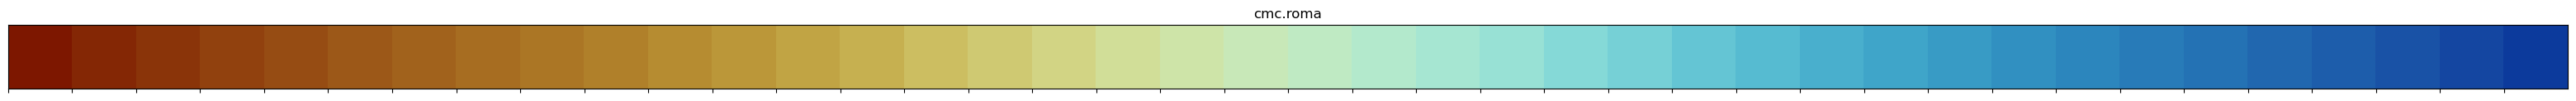

In [7]:
def create_palette(colormap_name, indices):
    try:
        colormap = plt.get_cmap(colormap_name)
        palette = colormap(indices)
        return palette
    except ValueError:
        print(f"Colormap '{colormap_name}' is not found.")
        return None

def display_palette(palette, title):
    if palette is not None:
        sns.palplot(palette)
        plt.title(title)
    else:
        print(f"Palette for '{title}' could not be displayed.")

num_colors = 200
color_indices = np.linspace(0, 1, num_colors)
selected_indices = list(range(0, 200, 5))

# Dictionary to store palettes
palettes = {}

# Create palettes for each colormap
for colormap_name in ['cmc.roma']:
    palettes[colormap_name] = create_palette(colormap_name, color_indices[selected_indices])

# Optional: Display the palettes
for name, palette in palettes.items():
    display_palette(palette, name)

plt.show()

In [9]:
def plot_heatmap(data, ax, title):
    hb = ax.hexbin(data['playerBodyPosition_X_Rounded'], data['playerBodyPosition_Z_Rounded'], gridsize=100, cmap='cividis', vmin=1, vmax=300)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    return hb


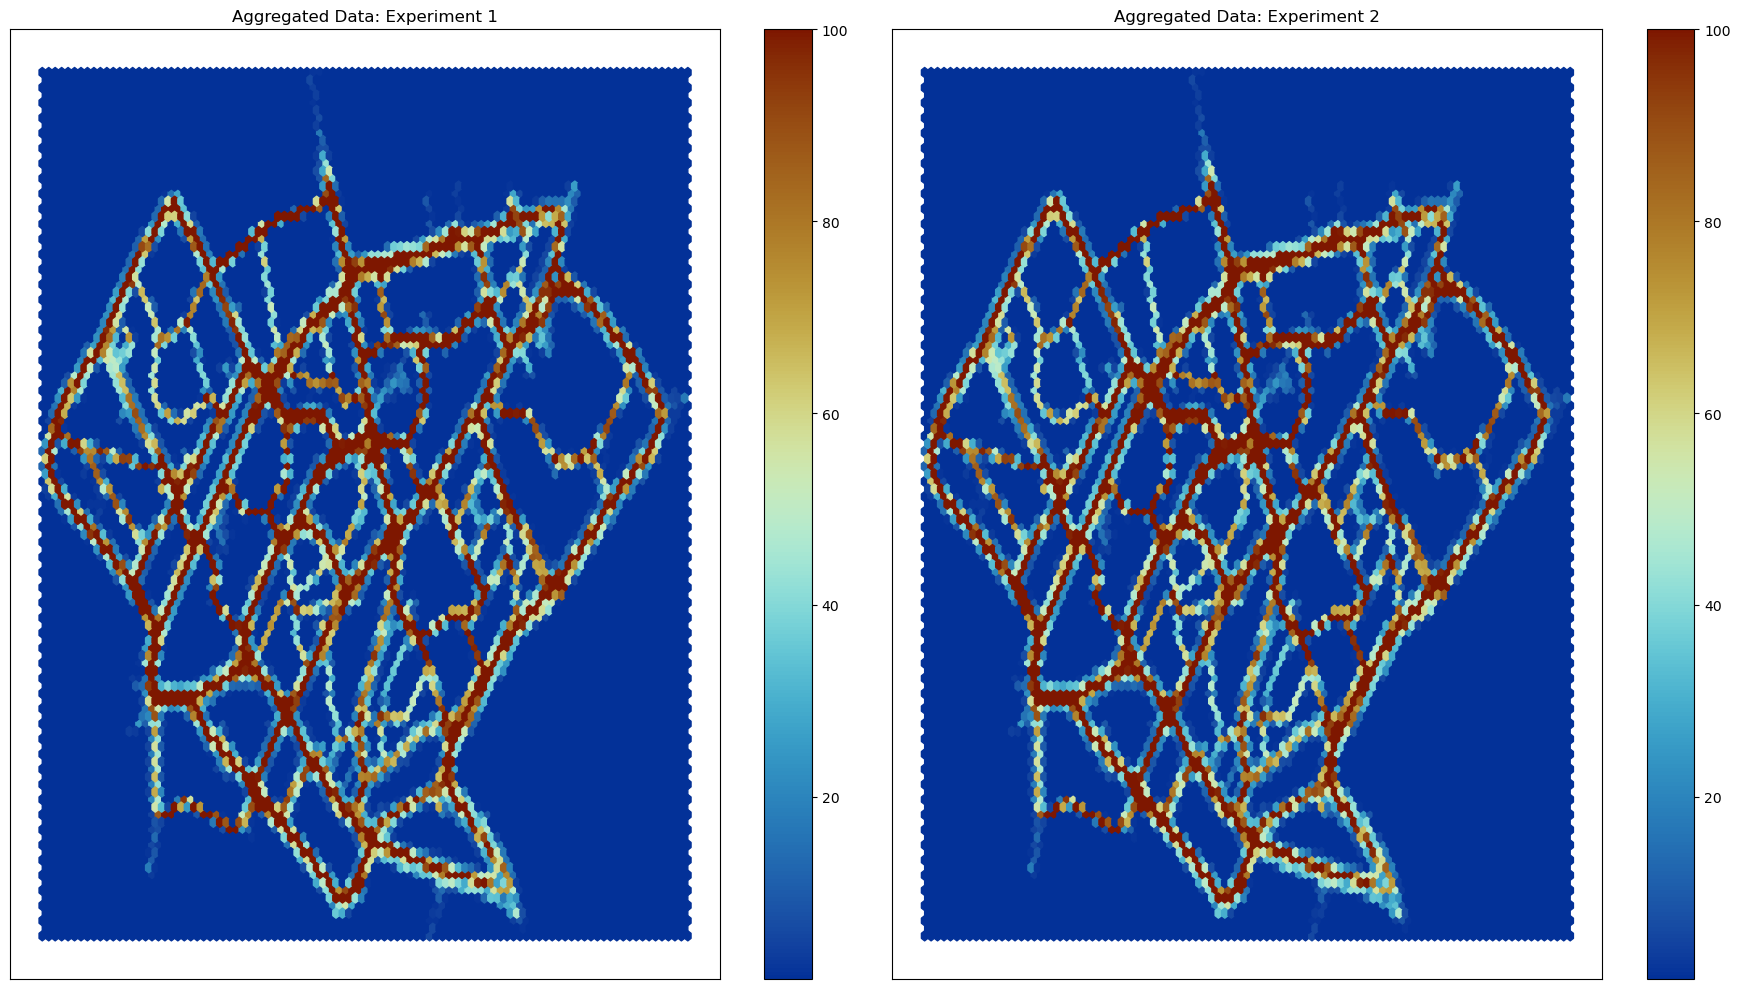

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import cmcrameri.cm as cmc

def expand_data(data):
    freq_table = data.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')
    freq_table['count'] = freq_table['count'].clip(upper=max_visits)
    return freq_table.loc[freq_table.index.repeat(freq_table['count'])]

def plot_heatmap(data, ax, title):
    hb = ax.hexbin(data['playerBodyPosition_X_Rounded'], data['playerBodyPosition_Z_Rounded'], gridsize=100, cmap='cmc.roma_r', vmin=1, vmax=100)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    return hb
max_visits = 1  #  cap as needed

# Expanding data for heatmap
expanded_exp1_data = expand_data(final_data1)
expanded_exp2_data = expand_data(final_data2)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(18, 10), facecolor='white')
hb1 = plot_heatmap(expanded_exp1_data, axs[0], 'Aggregated Data: Experiment 1')
hb2 = plot_heatmap(expanded_exp2_data, axs[1], 'Aggregated Data: Experiment 2')

# Adjusting colorbar to be consistent across both plots
fig.colorbar(hb1, ax=axs[0], orientation='vertical')
fig.colorbar(hb2, ax=axs[1], orientation='vertical')

plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Two_Experiments_AggregatedSessions.png", pad_inches=0.3)
plt.show()


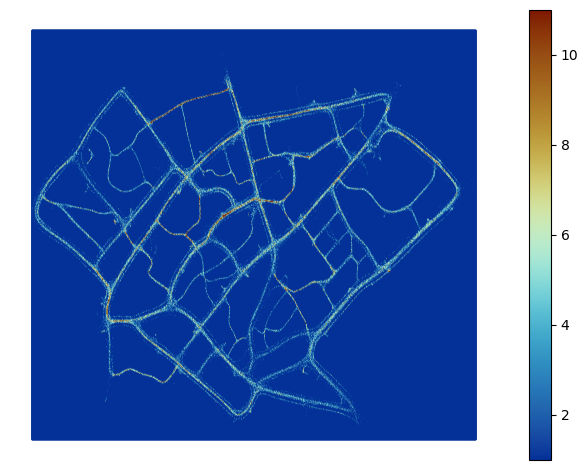

In [11]:
def expand_data(data):
    freq_table = data.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')
    freq_table['count'] = freq_table['count'].clip(upper=max_visits)
    return freq_table.loc[freq_table.index.repeat(freq_table['count'])]

def plot_heatmap(data, ax):
    hb = ax.hexbin(data['playerBodyPosition_X_Rounded'], data['playerBodyPosition_Z_Rounded'], gridsize=1000, cmap='cmc.roma_r', vmin=1, vmax=11)
    ax.set_xticks([])
    ax.set_yticks([])
    return hb


# Expanding data for heatmap
expanded_concat = expand_data(final_data)

# Plotting
fig, axs = plt.subplots(1, 1, facecolor='white')
hb1 = plot_heatmap(expanded_concat,axs)
axs.axis('off')
fig.colorbar(hb1, ax=axs, orientation='vertical')
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Two_Experiments_AggregatedSessions.png", pad_inches=0.3)
plt.show()

In [12]:
expanded_exp2_data.head()

,playerBodyPosition_X_Rounded,playerBodyPosition_Z_Rounded,count
0,-442.9,39.4,1
1,-441.8,39.2,1
2,-441.8,42.5,1
3,-441.6,37.4,1
4,-441.5,38.6,1


In [13]:
resampled_data_2S1.SubjectID.astype(int).unique()

array([ 365,  479, 1754, 2258, 2361, 2693, 3246, 3310, 3572, 3976, 4176,
       4597, 4796, 4917, 5238, 5531, 5741, 6642, 7093, 7264, 7412, 7842,
       8007, 8469, 8673, 8695, 9472, 9502, 9586, 9601])

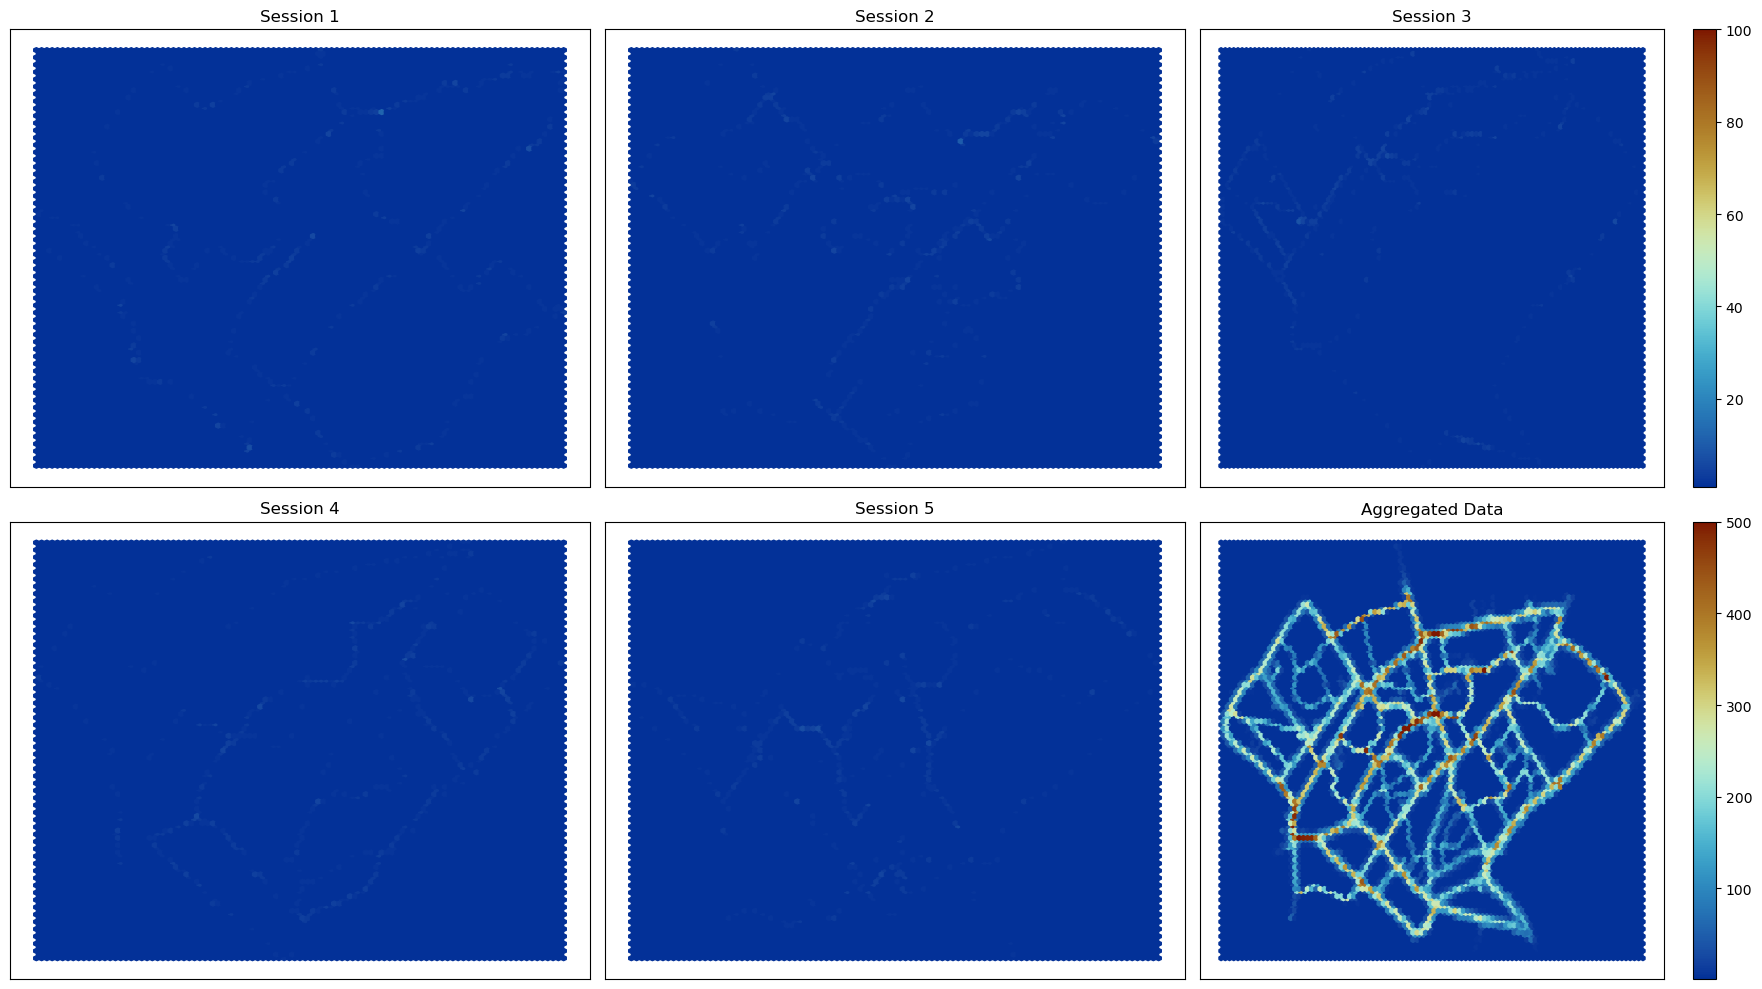

In [14]:
# Identify unique sessions
unique_sessions = resampled_data_2S['Session'].astype(int).unique()
resampled_data_2S['SubjectID'] = resampled_data_2S['SubjectID'].astype(int)

resampled_data_2S_1P = resampled_data_2S[resampled_data_2S['SubjectID'] == 8673]
# Define the maximum number of visits per location
max_visits = 1  #  cap as needed

# Create a grid of subplots - 3 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(18, 10), facecolor='white')  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array for easy indexing

# Iterate over sessions and create a heatmap for each
for i, session in enumerate(unique_sessions):
    # Filter data for the current session
    session_data = resampled_data_2S_1P[(resampled_data_2S_1P['Session'] == session)]

    # Create a frequency table
    freq_table = session_data.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')

    # Cap the frequencies
    freq_table['count'] = freq_table['count'].clip(upper=max_visits)

    # Expand the data based on capped frequencies
    expanded_data = freq_table.loc[freq_table.index.repeat(freq_table['count'])]

    # Create the heatmap with adjusted data in the ith subplot
    ax = axs[i]
    hb = ax.hexbin(expanded_data['playerBodyPosition_X_Rounded'], expanded_data['playerBodyPosition_Z_Rounded'], gridsize=100, cmap='cmc.roma_r', vmin=1, vmax=100)
    ax.set_title(f'Session {session}')
     # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    if i in [2]:
        fig.colorbar(hb, ax=ax, orientation='vertical')
    

# Aggregate heatmap for all sessions in the sixth plot
all_data = resampled_data_2S
all_freq_table = all_data.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')
all_freq_table['count'] = all_freq_table['count'].clip(upper=max_visits)
expanded_all_data = all_freq_table.loc[all_freq_table.index.repeat(all_freq_table['count'])]
ax = axs[5]  # Sixth subplot
hb_all = ax.hexbin(expanded_all_data['playerBodyPosition_X_Rounded'], expanded_all_data['playerBodyPosition_Z_Rounded'], gridsize=100, cmap='cmc.roma_r', vmin=1, vmax=500)
ax.set_title('Aggregated Data')
# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(hb_all, ax=ax, orientation='vertical')
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Participants_Exploration_Sessions.png",  bbox_inches="tight",
            pad_inches=0.3)
plt.show()

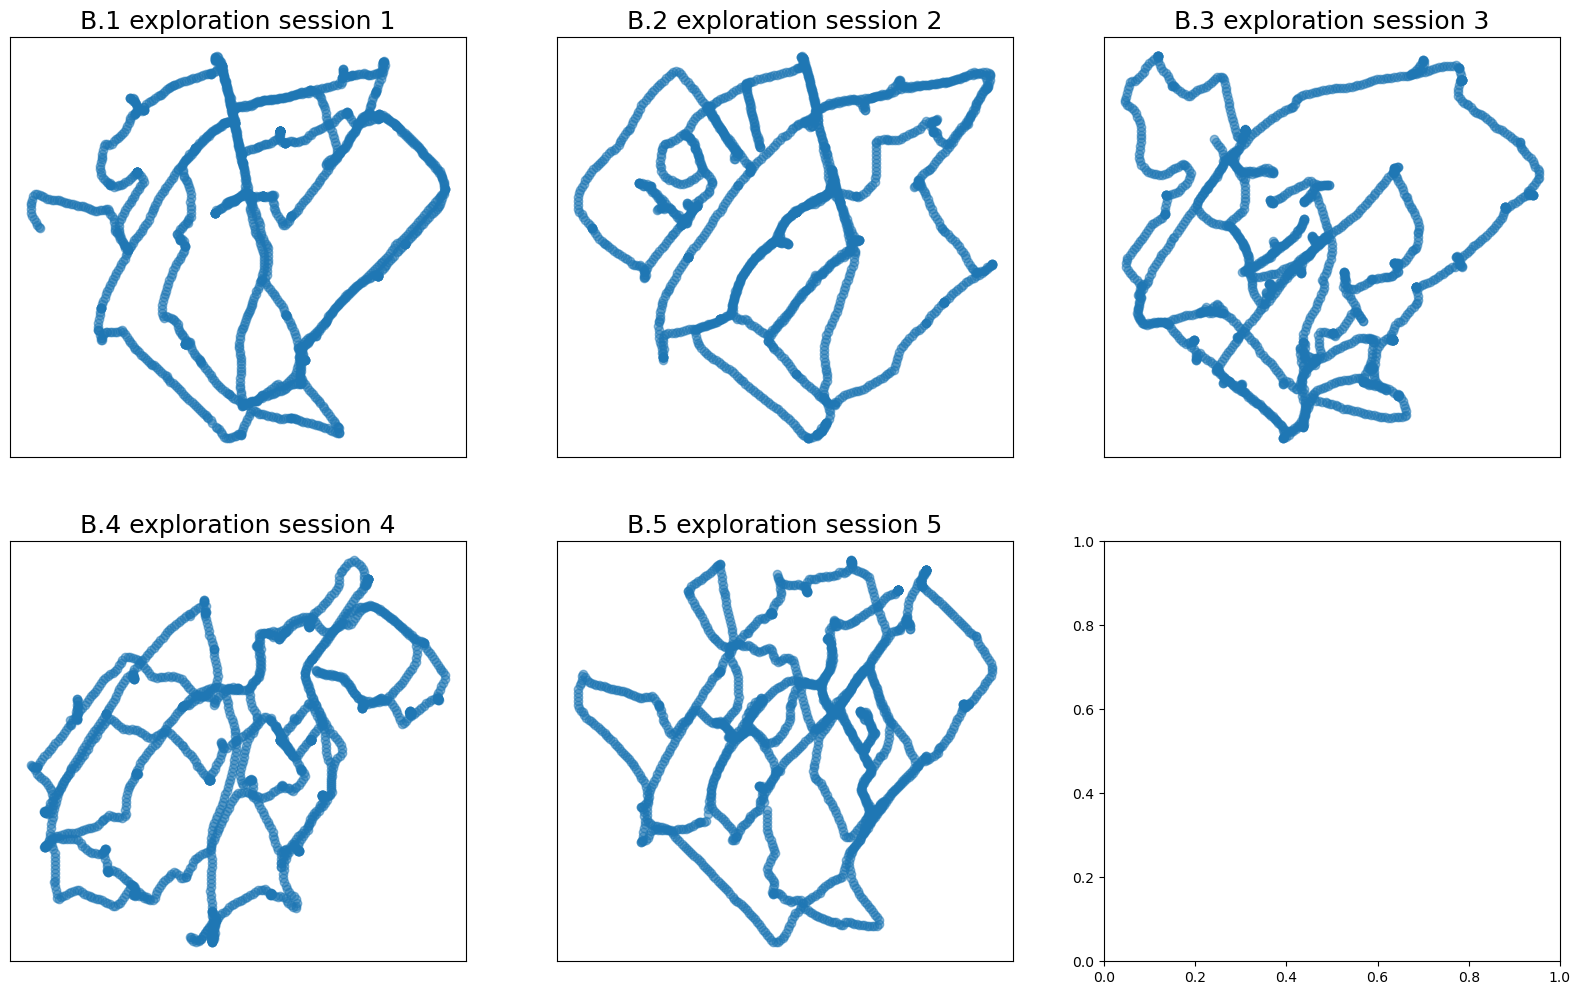

In [15]:
# Identify unique sessions
One_Subject = resampled_data_2S[resampled_data_2S.SubjectID == 1031]
unique_sessions = One_Subject['Session'].astype(int).unique()

# Create a grid of subplots - 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(20, 12), facecolor='white')  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array for easy indexing

# Set alpha value
alpha_value = 0.5  # Adjust this value as needed for transparency

# Iterate over sessions and create a point plot for each
for i, session in enumerate(unique_sessions):
    # Filter data for the current session
    session_data = One_Subject[One_Subject['Session'] == session]

    # Create the point plot in the ith subplot
    ax = axs[i]
    ax.scatter(session_data['playerBodyPosition_X_Rounded'], session_data['playerBodyPosition_Z_Rounded'], alpha=alpha_value)
    ax.set_title(f'B.{session} exploration session {session}', fontsize=18)
    
    # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust other settings or add more customizations as needed

# Show the plot
plt.show()

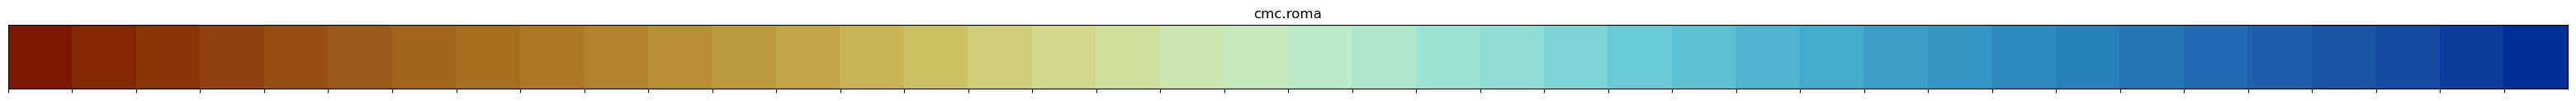

In [8]:
def create_palette(colormap_name, indices):
    try:
        colormap = plt.get_cmap(colormap_name)
        palette = colormap(indices)
        return palette
    except ValueError:
        print(f"Colormap '{colormap_name}' is not found.")
        return None

def display_palette(palette, title):
    if palette is not None:
        sns.palplot(palette)
        plt.title(title)
    else:
        print(f"Palette for '{title}' could not be displayed.")

num_colors = 40
color_indices = np.linspace(0, 1, num_colors)
selected_indices = list(range(0, 40, 1))

# Dictionary to store palettes
palettes = {}

# Create palettes for each colormap
for colormap_name in ['cmc.roma']:
    palettes[colormap_name] = create_palette(colormap_name, color_indices[selected_indices])

# Optional: Display the palettes
for name, palette in palettes.items():
    display_palette(palette, name)

plt.show()

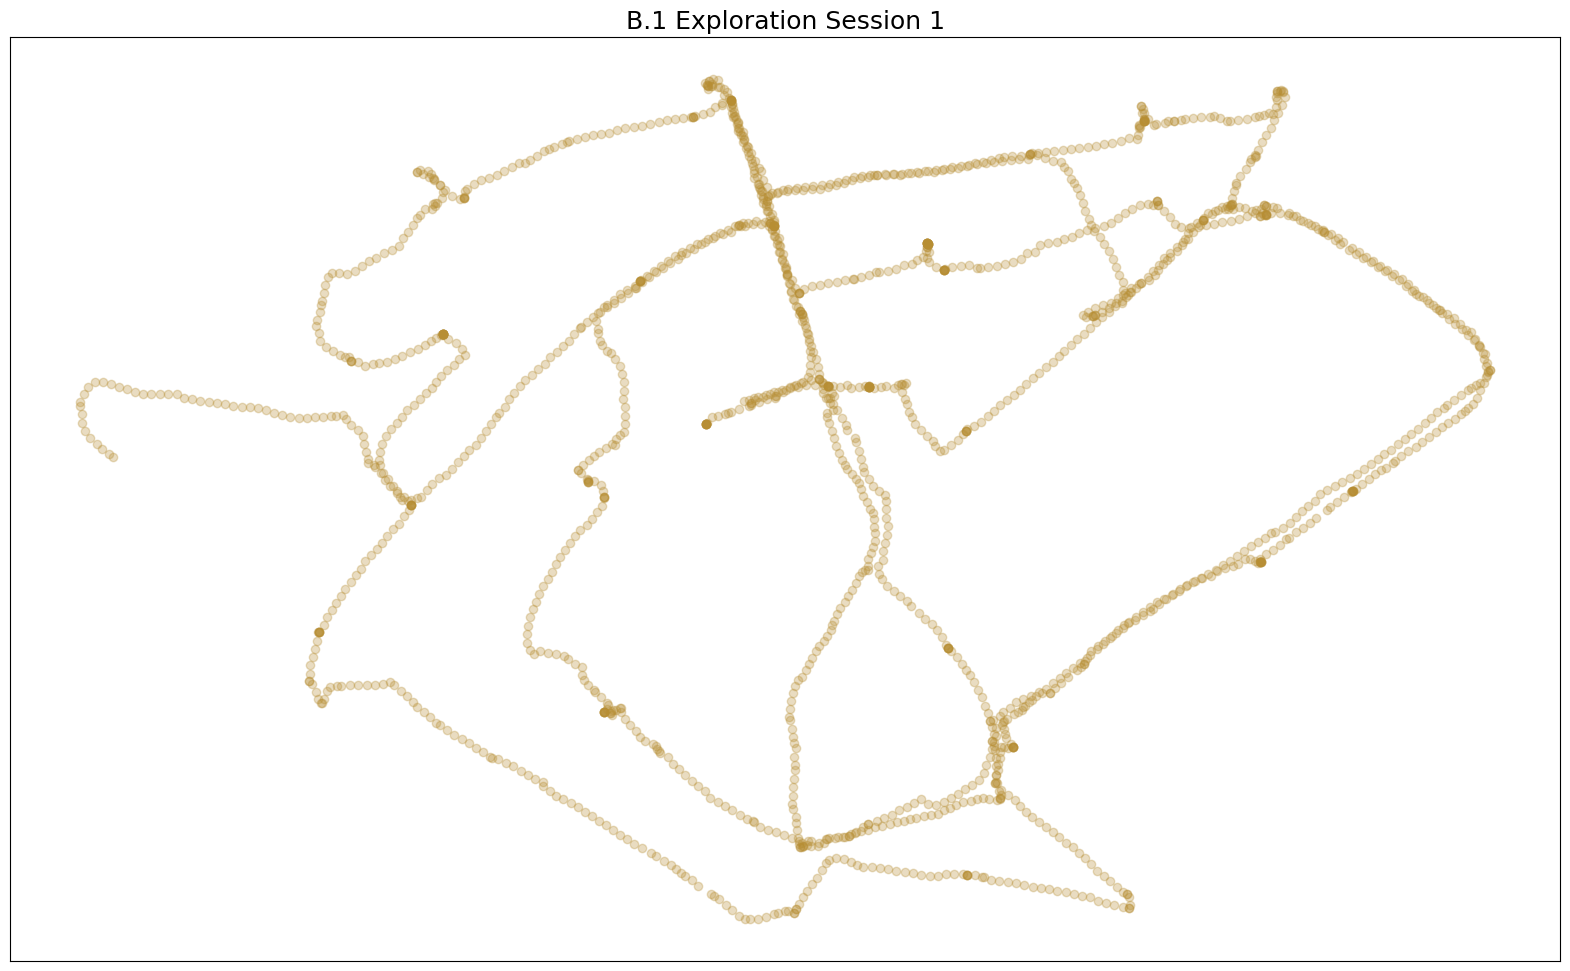

In [17]:


# Assuming resampled_data_2S is your DataFrame and already defined in your environment.

# Identify unique sessions
One_Subject_One_Session = resampled_data_2S[(resampled_data_2S.SubjectID == 1031) & (resampled_data_2S.Session == 1)]

# Create a single subplot
fig, ax = plt.subplots(1, 1, figsize=(20, 12), facecolor='white')  # Adjust the figure size as needed

# Set alpha value
alpha_value = 0.3  # Adjust this value as needed for transparency

# Create the point plot
ax.scatter(One_Subject_One_Session['playerBodyPosition_X_Rounded'], One_Subject_One_Session['playerBodyPosition_Z_Rounded'], color="#b78e33" ,alpha=alpha_value)

# Optionally set a title for the plot
ax.set_title('B.1 Exploration Session 1', fontsize=18)
    
# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# Adjust other settings or add more customizations as needed
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/One_Participant_exploration.png",  bbox_inches="tight",
            pad_inches=0.3, transparent=True)
# Show the plot
plt.show()


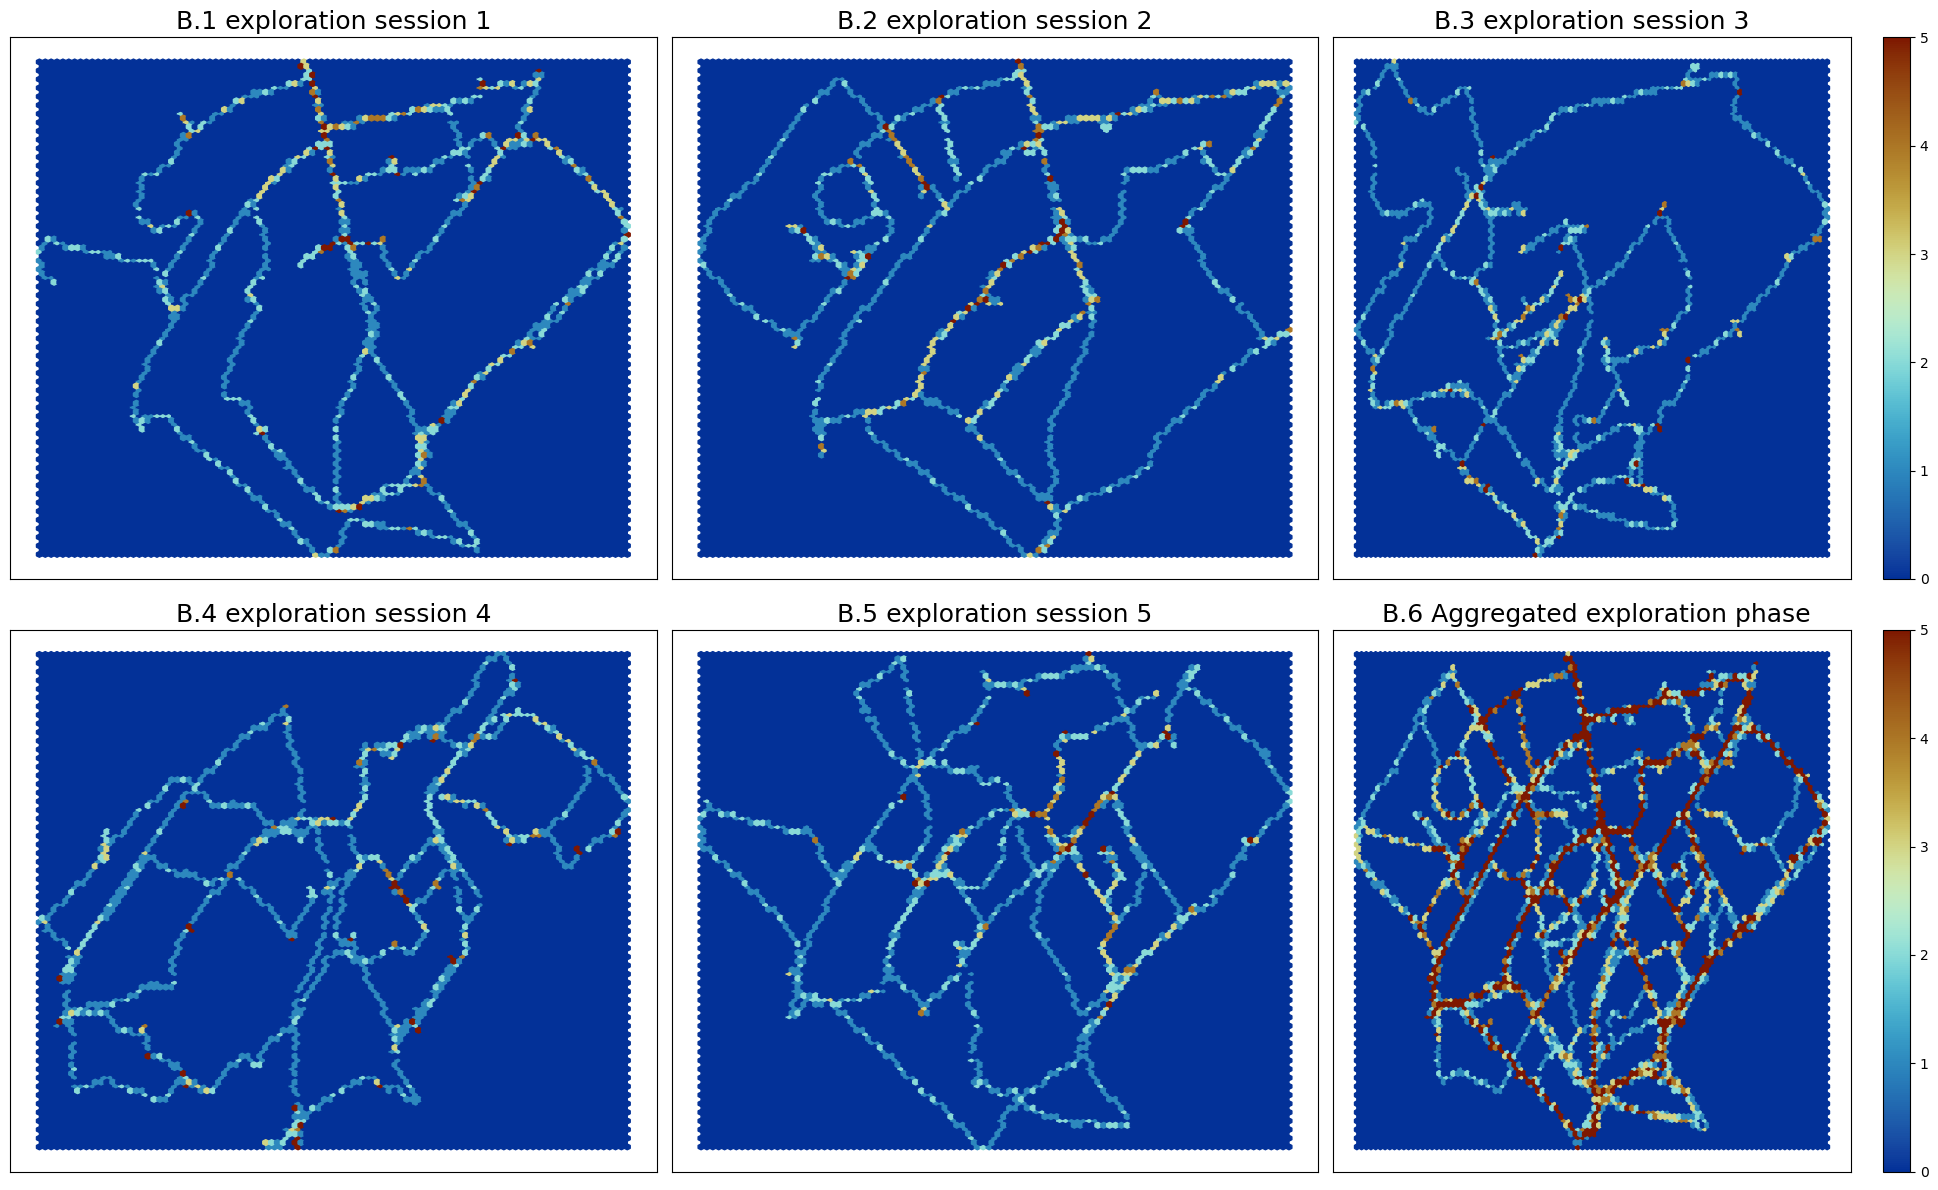

In [18]:
# Identify unique sessions
One_Subject = resampled_data_2S[resampled_data_2S.SubjectID == 1031]
unique_sessions = One_Subject['Session'].astype(int).unique()

# Define the maximum number of visits per location
max_visits = 1  #  cap as needed

# Create a grid of subplots - 3 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(20, 12),  facecolor='white')  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array for easy indexing

# Iterate over sessions and create a heatmap for each
for i, session in enumerate(unique_sessions):
    # Filter data for the current session
    session_data = One_Subject[One_Subject['Session'] == session]

    # Create a frequency table
    freq_table = session_data.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')

    # Cap the frequencies
    freq_table['count'] = freq_table['count'].clip(upper=max_visits)

    # Expand the data based on capped frequencies
    expanded_data = freq_table.loc[freq_table.index.repeat(freq_table['count'])]

    # Create the heatmap with adjusted data in the ith subplot
    ax = axs[i]
    hb = ax.hexbin(expanded_data['playerBodyPosition_X_Rounded'], expanded_data['playerBodyPosition_Z_Rounded'], gridsize=100, cmap='cmc.roma_r', vmin=0, vmax=5)
    ax.set_title(f'B.{session} exploration session {session}',  fontsize=18)
     # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    if i in [2]:
        fig.colorbar(hb, ax=ax, orientation='vertical')
        
    

# Aggregate heatmap for all sessions in the sixth plot
all_data = One_Subject
all_freq_table = all_data.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')
all_freq_table['count'] = all_freq_table['count'].clip(upper=max_visits)
expanded_all_data = all_freq_table.loc[all_freq_table.index.repeat(all_freq_table['count'])]
ax = axs[5]  # Sixth subplot
hb_all = ax.hexbin(expanded_all_data['playerBodyPosition_X_Rounded'], expanded_all_data['playerBodyPosition_Z_Rounded'], gridsize=100, cmap='cmc.roma_r', vmin=0, vmax=5)
ax.set_title(' B.6 Aggregated exploration phase',  fontsize=18)
# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(hb_all, ax=ax, orientation='vertical')
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/One_Participant_Exploration_Sessions.png",  bbox_inches="tight",
            pad_inches=0.3)
plt.show()

In [19]:
unique_sessions + 2

array([3, 4, 5, 6, 7])

In [3]:
Coverage =  pd.read_csv('/Volumes/TwoTeras/Graph_Stuff/CSVs/Unique_NodeVisit_Ratios.csv')

In [9]:
palettes['cmc.roma'][[39, -10, -24 ,-30, -40]]

array([[9.82400e-03, 1.92129e-01, 5.96704e-01, 1.00000e+00],
       [2.03709e-01, 5.84989e-01, 7.65902e-01, 1.00000e+00],
       [8.24755e-01, 8.50392e-01, 5.52561e-01, 1.00000e+00],
       [7.17725e-01, 5.57617e-01, 2.00115e-01, 1.00000e+00],
       [4.92325e-01, 9.07870e-02, 7.60000e-05, 1.00000e+00]])

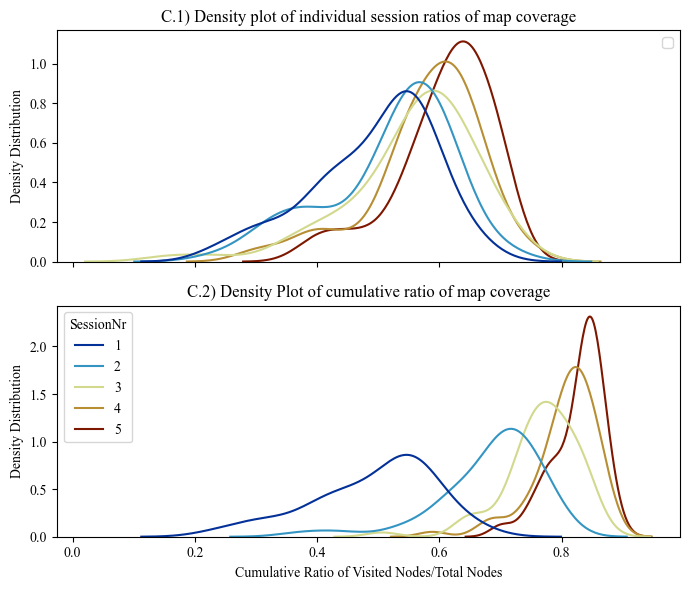

In [12]:
# Assuming df_total_new is pre-loaded and contains the necessary columns

custom_palette =  ["#033198", "#3495c3", "#d2d98d", "#b78e33", "#7e1700"]
# Filter out the control group for plotting
filtered_df = Coverage[Coverage['Experiment'] != 'control'].copy()
plt.rcParams['font.family'] = 'Times New Roman'

# Set up the matplotlib figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(7, 6), sharex=True)  # Adjusted figure size for better layout

# KDE plot for IndividualRatio
sns.kdeplot(data=filtered_df, x='IndividualRatio', hue='SessionNr', palette=custom_palette, ax=axes[0])
axes[0].set_xlabel('Ratio of Visited Nodes/Total Nodes Over One Session')
axes[0].set_ylabel('Density Distribution')
axes[0].set_title('C.1) Density plot of individual session ratios of map coverage')

# KDE plot for CummulativeRatio
sns.kdeplot(data=filtered_df, x='CummulativeRatio', hue='SessionNr', palette=custom_palette, ax=axes[1])
axes[1].set_xlabel('Cumulative Ratio of Visited Nodes/Total Nodes')
axes[1].set_ylabel('Density Distribution')
axes[1].set_title('C.2) Density Plot of cumulative ratio of map coverage')

# Adjust legend
axes[0].legend([])

# Improve the layout
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Coverage_Ratios.png",  bbox_inches="tight",
            pad_inches=0.3)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


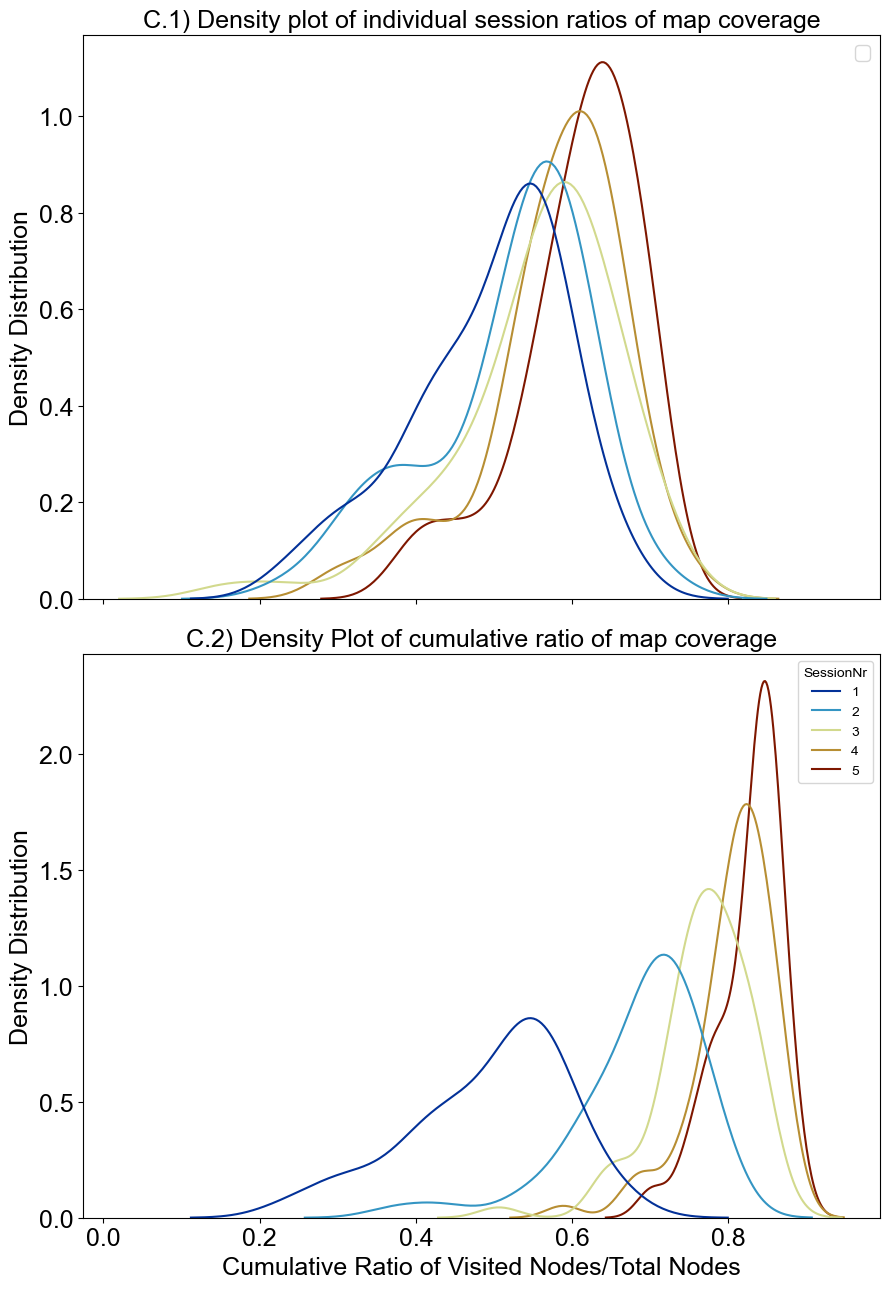

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_total_new is pre-loaded and contains the necessary columns

custom_palette = ["#033198", "#3495c3", "#d2d98d", "#b78e33", "#7e1700"]
# Filter out the control group for plotting
filtered_df = Coverage[Coverage['Experiment'] != 'control'].copy()
plt.rcParams['font.family'] = 'Arial'

# Set up the matplotlib figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(9,13), sharex=True)  # Adjusted figure size for better layout

# KDE plot for IndividualRatio
sns.kdeplot(data=filtered_df, x='IndividualRatio', hue='SessionNr', palette=custom_palette, ax=axes[0])
axes[0].set_xlabel('Ratio of Visited Nodes/Total Nodes Over One Session', fontsize=18)
axes[0].set_ylabel('Density Distribution', fontsize=18)
axes[0].set_title('C.1) Density plot of individual session ratios of map coverage', fontsize=18)
axes[0].tick_params(labelsize=18) 

# KDE plot for CummulativeRatio
sns.kdeplot(data=filtered_df, x='CummulativeRatio', hue='SessionNr', palette=custom_palette, ax=axes[1])
axes[1].set_xlabel('Cumulative Ratio of Visited Nodes/Total Nodes', fontsize=18)
axes[1].set_ylabel('Density Distribution', fontsize=18)
axes[1].set_title('C.2) Density Plot of cumulative ratio of map coverage', fontsize=18)
axes[1].tick_params(labelsize=18)  

# Adjust legend for better visibility
axes[0].legend(fontsize=14)  # you can adjust this size as needed

# Improve the layout
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Coverage_Ratios.png",  bbox_inches="tight",
            pad_inches=0.3)
plt.show()


In [19]:
filtered_df.head()

,ParticipantID,SessionNr,IndividualNodeCount,Experiment,CummulativeNodeCount,IndividualRatio,CummulativeRatio
0,365,1,90,Exp1,90,0.569620,0.569620
1,365,2,101,Exp1,111,0.639241,0.702532
2,365,3,90,Exp1,115,0.569620,0.727848
3,365,4,90,Exp1,117,0.569620,0.740506
4,365,5,100,Exp1,121,0.632911,0.765823


In [ ]:
mapCoverageLast = Coverage[(Coverage.SessionNr == 5) & (Coverage.Experiment != 'Control') ]
mapCoverageLast.CummulativeRatio.mean()

In [ ]:
oneSub_OneSes = resampled_data_2S[(resampled_data_2S.SubjectID == 1031) & (resampled_data_2S.Session == 1)]
one_freq_table = oneSub_OneSes.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')
one_freq_table['count'] = one_freq_table['count'].clip(upper=max_visits)
expanded_one_data = one_freq_table.loc[one_freq_table.index.repeat(one_freq_table['count'])]
expanded_one_data.head()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 10), facecolor='white')  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array for easy indexing
ax = axs[0]  # Sixth subplot
hb_all = ax.hexbin(expanded_one_data['playerBodyPosition_X_Rounded'], expanded_one_data['playerBodyPosition_Z_Rounded'], gridsize=100, cmap='viridis', vmin=1, vmax=5)
ax.set_title('First exploration of one subject in the city')
# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(hb_all, ax=ax, orientation='vertical')
plt.tight_layout()
plt.show()



In [ ]:
# Assuming final_data contains your data
x = final_data['playerBodyPosition_X_Rounded']
y = final_data['playerBodyPosition_Z_Rounded']

# Create a frequency table
freq_table = final_data.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')

# Cap the frequencies
max_visits =1 # Set your cap value here
freq_table['count'] = freq_table['count'].clip(upper=max_visits)

# Expand the data based on capped frequencies
expanded_data = freq_table.loc[freq_table.index.repeat(freq_table['count'])]

# Create the heat map with adjusted data
plt.hexbin(expanded_data['playerBodyPosition_X_Rounded'], expanded_data['playerBodyPosition_Z_Rounded'], gridsize=70, cmap='viridis')
plt.colorbar(label='Density')
plt.show()

In [ ]:
sns.scatterplot(x=x, y=y, alpha=0.1)

In [ ]:
Map_data.to_csv('/Users/tracysanchezpacheco/Desktop/Map_data.csv', index=False)

In [ ]:
# Filter data by session and save to separate CSV files
unique_sessions = resampled_data['Session'].unique()
for session in unique_sessions:
    session_data = Map_data[Map_data['Session'] == session].copy()
    output_file = f'/Volumes/TwoTeras/Maps/Resample/session_{session}.csv'
    session_data.to_csv(output_file, index=False)

In [ ]:
# Extract the rounded X and Z coordinates

heat_data = resampled_data[['playerBodyPosition_Z_Rounded', 'playerBodyPosition_X_Rounded']].values.tolist()

# Create a Folium map
# The location is set to the first coordinate in the data for centering the map
map_center = [heat_data[0][0], heat_data[0][1]]
map = folium.Map(location=map_center, zoom_start=15)

# Add a HeatMap layer
HeatMap(heat_data).add_to(map)

# Save the map to an HTML file
map_file_path = '/Users/tracysanchezpacheco/Desktop/player_heatmap.html'  # Replace with your desired output path
map.save(map_file_path)